In [1]:
#import the API and getpass
from arcgis.gis import GIS
from getpass import getpass

#authenticate with your account (create a free one here: https://www.arcgis.com/home/createaccount.html)
gis = GIS("https://www.arcgis.com", "astrong_pnw", getpass())
print(gis)

········
GIS @ https://pnw.maps.arcgis.com


City of Sac has some cool data inside their open data site (data.cityofsacramento.org) such as :
* [On Street Parking](http://data.cityofsacramento.org/datasets/onstreetparking)
* [Signs](http://data.cityofsacramento.org/datasets/signs)
* [Streetlights](http://data.cityofsacramento.org/datasets/streetlights)
* [City Maintained Trees](http://data.cityofsacramento.org/datasets/city-maintained-trees)
* [And more!](http://data.cityofsacramento.org/datasets)

<Item title:"Streetlights" type:Feature Layer Collection owner:Publisher_SacCity>
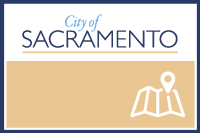

In [2]:
#Let's work with the Streetlights layer
lights = gis.content.get('ca7680fe3a734c6684c4b6f48e07548e')
lights

In [3]:
# Now let's query this data in pandas
from arcgis.features import FeatureLayer
import pandas as pd

#make query
feature_layer = FeatureLayer.fromitem(lights)
features = feature_layer.query()

#open features in pandas data frame 
df = features.df
df[:5]

,COLOR,COMMISSION_DATE,ESRI_OID,FIXTURE,GISOBJID,LAMP_TYPE,OBJECTID,OBJ_CODE,OWNER,PLAN_NO,POLE_TYPE,SERVICE_NO,WATTAGE,SHAPE
0,YES,1327276800000,1,None,100020032,HPS,31042,SLT-31042,DOT,E-1728,PT,866,100,"{'x': 6708015.8399988115, 'y': 1991906.3954418..."
1,YES,1327276800000,2,None,100020033,HPS,31043,SLT-31043,DOT,E-1728,PT,866,100,"{'x': 6708035.750063986, 'y': 1991695.36764863..."
2,YES,1327276800000,3,None,100020035,HPS,31048,SLT-31048,DOT,E-1728,PT,866,100,"{'x': 6708173.764551729, 'y': 1992057.76620204..."
3,NO,1327276800000,4,None,100018084,HPS,31054,SLT-31054,DOT,E-3169,PT,1454,100,"{'x': 6701356.888749808, 'y': 1994892.03907680..."
4,NO,1327276800000,5,None,100018085,HPS,31055,SLT-31055,DOT,E-3169,PT,1454,100,"{'x': 6701522.896619901, 'y': 1994872.35768571..."


**Calculation**

Energy Consumption (kWh) = System Input Wattage (kW) x Hours of Operation/Year

**Hours of Operation/Year**

We can assume street lights in Sacramento run for 9 hours a night, 9 * 365 days = 3,285 hours of operation a year. 

**KwH**

A kilowatt-hour is 1,000 watts used for one hour. To calculate KwH we simply need to divide our watt column by 1,000. 

In [4]:
#Can we calculate energy consumption by total wats? http://www.lightsearch.com/resources/lightguides/formulas.html
watt = df['WATTAGE']
watt = pd.to_numeric(watt)

#Get KwH from Watts
kwh = watt/1000
kwh[:5]

0    0.1
1    0.1
2    0.1
3    0.1
4    0.1
Name: WATTAGE, dtype: float64

In [5]:
#now we can calculate total energy consumption by mulitplying each KwH by the total hours of operation
energy_consumption = kwh * 3285
energy_consumption[:5]

0    328.5
1    328.5
2    328.5
3    328.5
4    328.5
Name: WATTAGE, dtype: float64

In [6]:
#add new field
df['E_CON'] = energy_consumption
df[:5]

,COLOR,COMMISSION_DATE,ESRI_OID,FIXTURE,GISOBJID,LAMP_TYPE,OBJECTID,OBJ_CODE,OWNER,PLAN_NO,POLE_TYPE,SERVICE_NO,WATTAGE,SHAPE,E_CON
0,YES,1327276800000,1,None,100020032,HPS,31042,SLT-31042,DOT,E-1728,PT,866,100,"{'x': 6708015.8399988115, 'y': 1991906.3954418...",328.5
1,YES,1327276800000,2,None,100020033,HPS,31043,SLT-31043,DOT,E-1728,PT,866,100,"{'x': 6708035.750063986, 'y': 1991695.36764863...",328.5
2,YES,1327276800000,3,None,100020035,HPS,31048,SLT-31048,DOT,E-1728,PT,866,100,"{'x': 6708173.764551729, 'y': 1992057.76620204...",328.5
3,NO,1327276800000,4,None,100018084,HPS,31054,SLT-31054,DOT,E-3169,PT,1454,100,"{'x': 6701356.888749808, 'y': 1994892.03907680...",328.5
4,NO,1327276800000,5,None,100018085,HPS,31055,SLT-31055,DOT,E-3169,PT,1454,100,"{'x': 6701522.896619901, 'y': 1994872.35768571...",328.5


In [7]:
#now we can publish our content up to our personal AGOL account 
#helpful: https://community.esri.com/thread/198777-xy-coordinates-in-pandas-dataframe-to-map

#write df to csv 
lights_csv = r"C:\Users\asa7362\Desktop\dev\local-gov-gis-solutions\python_api\streetlights.csv"
df.to_csv(lights_csv)

#add csv
item_prop = {'title':'Sac Streetlights Energy Consumption', 'type': 'CSV'}
csv_item = gis.content.add(item_prop, lights_csv)
print(f"item added to {gis}")

#publish item (!!FAILS HERE!!)
csv_item.publish()
print(f"item published to {gis}")

item added to GIS @ https://pnw.maps.arcgis.com
item published to GIS @ https://pnw.maps.arcgis.com
